# Self-Driving Car Engineer Nanodegree

## Project: *Finding Lane Lines on the Road*
***
In this project, I used different methods than those described in the text. The primary functions are contained in the modules "find_lane_lines" and "accumLines". The work flow is as follows:

* Pre-process the image
* Compute the image gradient 
* For each pixel with a large gradient, draw a line perpendicular to the gradient (this will be along the edge of the image) in a blank image, and accumulate all of the lines
* Threshold this accumulated image and fit the left and right sides with a linear line, these are the lane lines.

To gain robustness, I use create a history of the last several image frames. The result for the current frame will be the average of the history

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from find_lane_lines import *
from accumLines import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from time import time
%matplotlib inline

### Define some constants getting started

In [2]:
ROI_vertices = np.array( [[ (0,    1),
                            (0.45, 0.55),
                            (0.55, 0.55),
                            (1,    1)    ]])
history_size = 10

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


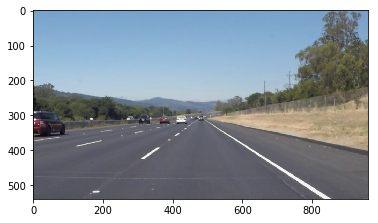

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### Create region of interest

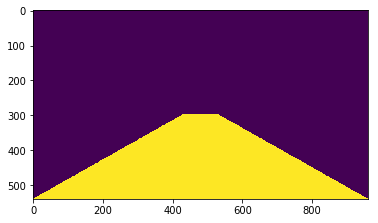

In [4]:
img_size = image.shape[0:2]
ROI = create_ROI(img_size, ROI_vertices)
plt.imshow(ROI)

### Pre-process image
- Create a gray-scale image by taking the mean of the red and green channel (remove the blue channel). This will make yellow and white the same.
- Adjust the image contrast along the rows inside the ROI
- Smooth out the image with a gaussian filter

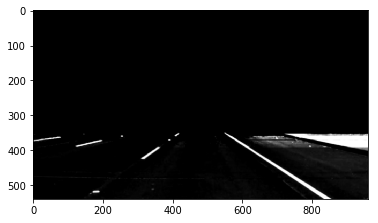

In [5]:
I, roi = pre_process_image(image,ROI)
img_size = I.shape[0:2]
plt.imshow(I,cmap='gray',vmin=0,vmax=255)
mpimg.imsave('preProcessed_image.jpg', I, cmap = 'gray')

### Find lines:
#### 1. Create voting landscape
- Compute the gradient (magnitude and direction) for the image above. The direction of the gradient is perpendicular to the edges. 
- Take a point with a large gradient, draw a line through that point with a direction perpendicular to the gradient. Write this line to a blank image. 
- Repeat this process for each point with a large gradient and accumulate the values in the blank image. The resulting image is shown below.

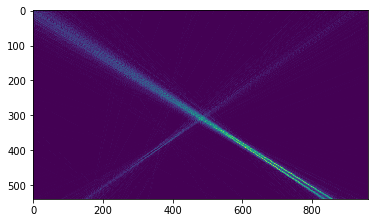

In [6]:
x1,x2 = locate_perpendicular_lines(I, roi)
VL = accumLines(x1,x2,img_size)
plt.imshow(VL)
mpimg.imsave('voteLandscape.jpg', VL)

#### 2. Compute mask and fit lines
- Next, smooth this with a gaussian filter, set everything outside the ROI to zero, and normalize each column of **A** to have the same sum. This normalization equalized the intensities created from dotted lines and solid lines. 
- Threshold the resulting image and use the mean x value of the mask to divide the image into left and right parts
- For each of the parts, fit the pixels of the mask with a linear line

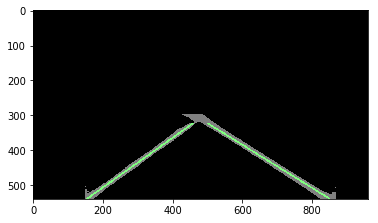

In [7]:
left_lane, right_lane, blurVL, maskVL = compute_lines(VL, roi)

# This code here is just to create an image for the write up.
left_lane = left_lane.astype(np.uint16)
right_lane = right_lane.astype(np.uint16)
line_img = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
cv2.line(line_img, (left_lane[0,1], left_lane[0,0]), (left_lane[1,1], left_lane[1,0]), (0,255,0), 3)
cv2.line(line_img, (right_lane[0,1], right_lane[0,0]), (right_lane[1,1], right_lane[1,0]), (0,255,0), 3)
maskandlines =  np.dstack((maskVL, maskVL, maskVL)).astype(np.uint8)*255
maskandlines = cv2.addWeighted(maskandlines, 0.5, line_img, 1, 0)

plt.imshow(maskandlines)
mpimg.imsave('voteLandscapeMask_withLines.jpg', maskandlines)

These steps are all written into the function *find_frames_lane_lines* in find_lane_lanes. Now, we just need a wrapper function to call it and output a modified image with the lines. 

### Create wrapper function

The wrapper function will accept an RGB frame as well as an element of class **History** defined in find_lane_lines. It will output the RGB frame with the lane lines annotated as well as the computation FPS given in the upper left corner. The computation FPS should be as fast or faster than the FSP of the actual video file.

The **Hisotry** class defines a variable for the voting landscape (VL), the left lane (LL) end points, and the right lane (RL) endpoints. Each of these variables will store the results from the last **history_size** number of frames. The LL and RL used to annotate the current frame will be the mean of the history. Additionally, the mean VL from the history is used to stabilize the current frames VL before calculating the current frames LL and RL.

In [8]:
# Create a tic-toc timer for computing FPS
_tstart_stack = []

def tic():
    _tstart_stack.append(time())

def toc():
    return (time() - _tstart_stack.pop())

In [9]:
def process_image(image, history, videoFPS):
    
    img = image.copy()
    LINE_COLOR = (255, 0, 0)
    THICKNESS = 11
    
    # Since with this video reader we do not know the size of the images before hand, we have to calculate the ROI for every single frame.
    ROI_vertices = np.array( [[ (0,1), (0.45, 0.55), (0.55, 0.55), (1, 1)    ]])
    img_size = image.shape[0:2]
    
    roi = create_ROI(img_size, ROI_vertices)
    
    tic()
    find_frames_lane_lines(img,roi,history)
    
    LL = history.left_lane.astype(np.uint16)
    RL = history.right_lane.astype(np.uint16)
    compTime = toc()
    
    FPS = 1. / compTime
    
    line_img = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)
    cv2.line(line_img, (LL[0,1], LL[0,0]), (LL[1,1], LL[1,0]), LINE_COLOR, THICKNESS)
    cv2.line(line_img, (RL[0,1], RL[0,0]), (RL[1,1], RL[1,0]), LINE_COLOR, THICKNESS)
    
    img = cv2.addWeighted(img, 0.8, line_img, 1, 0)
    
    if FPS > videoFPS:
        textColor = (0,255,0)
    else:
        textColor = (255,0,0)
        
    cv2.putText(img,'FPS = {0:.2f}'.format(FPS),(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, textColor, 2)
    
    return img

## Analyze test images

In [10]:
import os
image_names = os.listdir("test_images/")

for img_name in image_names:
    print('Processing {} ...'.format(img_name))
    image = mpimg.imread('{}{}'.format('test_images/', img_name))
    pimage = process_image(image, History(1), 1)
    mpimg.imsave('{}{}'.format('test_images/processed_', img_name), pimage)

Processing solidWhiteCurve.jpg ...
Processing solidWhiteRight.jpg ...
Processing solidYellowCurve.jpg ...
Processing solidYellowCurve2.jpg ...
Processing solidYellowLeft.jpg ...
Processing whiteCarLaneSwitch.jpg ...


## Analyze videos

Before we can analyze the videos with the MoviePy library, we need a wrapper function so we can call the process_image function with extra imputs.


In [11]:
def my_transformation(clip, par1, par2):
    def new_tranformation(image):
        return process_image(image, par1, par2)
    return clip.fl_image(new_tranformation)

Now, we can use **.fx** to process the videos

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
videoFPS = clip1.fps

# Make sure we have a clean history
hstry = History(history_size)

white_clip = clip1.fx(my_transformation, hstry, videoFPS) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 17.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
videoFPS = clip2.fps

# Make sure we have a clean history
hstry = History(history_size)

yellow_clip = clip2.fx(my_transformation, hstry, videoFPS) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:51<00:00, 13.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 52.1 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [16]:
extra_output = 'extra.mp4'
clip3 = VideoFileClip('challenge.mp4')
videoFPS = clip3.fps

# Make sure we have a clean history
hstry = History(history_size)

extra_clip = clip3.fx(my_transformation, hstry, videoFPS) #NOTE: this function expects color images!!
%time extra_clip.write_videofile(extra_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:23<00:00, 10.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 24.6 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(extra_output))